# TODO
- Clean demographic data
- Demographic EDA
- Scale police report demographic rates by census demographic rates to adjust for uneven sampling
- Geospatial plot of interview card data using location in table

# Analysis of Disparate Treatment of Demographic Groups by the New Orleans Police Force in 2022
-----------
Hayden Outlaw & Mikey Sison - Spring 2023 - Tulane University


## Introduction
------
### TODO

## Loading Libraries

In [67]:
import pandas as pd
import numpy as np
import os
import sklearn as sk
import time
import seaborn as sns

# force pandas to display all columns globally
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Loading Data
----
The Field Interview Card data is sourced from [data.nola.gov](https://data.nola.gov/Public-Safety-and-Preparedness/Stop-and-Search-Field-Interviews-/kitu-f4uy), which is an online third-party resource for data and metrics about the city of New Orleans. This data was originally published by the New Orleans Police Department, and was most recently loaded here on **February 24th, 2023**. This data contains a unique primary key, an NOPD reference item, the district and zone of the interview, the officer's district assignment, a description of the stop, the actions taken, information about vehicles involved if the interview was the result of an incident involving vehicles, information about the subject, and location. Note that the locations involved have been anonymized - the data only contains fidelity to a zip code and a block, and is maintained that way out of privacy concerns. Interview data was also available dating back to at least 1993, albeit sparsely, but this project only focuses on interviews conducted on or after January 1st, 2022.


The Demographic and Housing data for New Orleans is sourced from the American Community Survey via [data.census.gov](https://data.census.gov/table?q=new+orleans&tid=ACSDP1Y2021.DP05). This data is the most recent demographic data for the city, but for estimates of demographics for the 2021 year. This is because these studies usually take a year to publish, so there is a one year lag in most recent metrics. This table contains the estimated count of gender, age ranges, and racial class membership for New Orleans, as well as a margin of error estimate. While the total sample size is 376,971, the metrics are estimates, although the sample size is large enough that the percent margin of error is under 1% for all reported attributes. 

In [56]:
# load in interview data
interview_data = pd.read_csv('../data/Interview_Cards_Filtered.csv')
interview_data.index.name = "ID"
interview_data.head(3)

,FieldInterviewID,NOPD_Item,EventDate,District,Zone,OfficerAssignment,StopDescription,ActionsTaken,VehicleYear,VehicleMake,VehicleModel,VehicleStyle,VehicleColor,SubjectID,SubjectRace,SubjectGender,SubjectAge,SubjectHasPhotoID,SubjectHeight,SubjectWeight,SubjectEyeColor,SubjectHairColor,SubjectDriverLicState,CreatedDateTime,LastModifiedDateTime,Longitude,Latitude,Zip,BlockAddress
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,607431,B2364223,2/23/23 14:26,8,E,8th District,CALL FOR SERVICE,Stop Results: No action taken;Subject Type: Pe...,NaN,NaN,NaN,NaN,NaN,695359.0,WHITE,MALE,NaN,Yes,74.0,180.0,Brown,Black,LA,2/23/23 15:14,NaN,-90.059982,29.963337,70116.0,Royal St & Esplanade Av
1,607433,B2383823,2/23/23 14:13,5,Q,5th District,CALL FOR SERVICE,Stop Results: No action taken;Subject Type: Pe...,NaN,NaN,NaN,NaN,NaN,695361.0,BLACK,FEMALE,NaN,No,68.0,140.0,Brown,Brown,NaN,2/23/23 17:35,NaN,-90.016421,29.966743,70117.0,005XX N Claiborne Av
2,607430,B2342223,2/23/23 13:02,7,F,7th District,TRAFFIC VIOLATION,Stop Results: Verbal Warning;Subject Type: Dri...,2003.0,TOYOTA,TACOMA,PICK UP,BEIGE,695358.0,BLACK,FEMALE,NaN,Yes,65.0,110.0,Brown,Black,LA,2/23/23 13:13,NaN,-89.992275,30.023754,NaN,Dwyer Rd & Sandhurst Dr


In [57]:
demographic_data = pd.read_csv('../data/ACSDemographicHousingData.csv')
demographic_data.set_index("Label (Grouping)", inplace = True)
demographic_data.head(40)

,"New Orleans city, Louisiana!!Estimate","New Orleans city, Louisiana!!Margin of Error","New Orleans city, Louisiana!!Percent","New Orleans city, Louisiana!!Percent Margin of Error"
Label (Grouping),,,,
SEX AND AGE,NaN,NaN,NaN,NaN
Total population,"376,971",*****,"376,971",(X)
Male,"178,394",±298,47.3%,±0.1
Female,"198,577",±298,52.7%,±0.1
Sex ratio (males per 100 females),89.8,±0.3,(X),(X)
Under 5 years,"20,709",±142,5.5%,±0.1
5 to 9 years,"20,333","±2,003",5.4%,±0.5
10 to 14 years,"21,508","±1,918",5.7%,±0.5
15 to 19 years,"19,844",±646,5.3%,±0.2


## Cleaning Data

The total size of the interview card dataset is 16500 observations of 29 attributes each. This includes all observations from January 1st, 2022 through the most recent version of the data downloaded.

In [58]:
# get size of interview data
interview_data.shape

(16500, 29)

These are all the counts of missing data ([numpy NaN objects](https://numpy.org/doc/stable/reference/constants.html)) prseent in the field interview cards data set. Some columns are inherently non-sparse, such as teh primary key `FieldInterviewID` or `NOPD_Item`, as well as the boolean attribute `SubjectHasPhotoID` in which the variable is marked as False unless shown to be otherwise true. Notably, the information about vehicles involved tends to be sparse, but this is most likely accounted for in incidents not involving vehicles at all, and so presents no logical issues. There are various reasons why subject information could be missing, such as officer error, indeterminate attributes (low lighting, incident was too short to collect definitive attributes, etc.,), lack of collection (ID or driver's licence was never needed to be checked), or anonymization out of safety concerns. We do not assert that the sparsity of these attributes is independent of the attributes of the subjects themselves - `SubjectRace` is one of the least sparse attributes in the data set, as well as `SubjectGender`, which can be determined visually by the officer. Therefore, these sparse observations will not be dropped, but will be accounted for separately. As well, `SubjectAge` is entirely sparse, and will be dropped as there is no data whatsoever in that attribute.

In [59]:
# get number of nan entries for each attribute
print(interview_data.isna().sum())

FieldInterviewID             0
NOPD_Item                    0
EventDate                    0
District                     0
Zone                         0
OfficerAssignment            0
StopDescription              0
ActionsTaken               126
VehicleYear               8004
VehicleMake               7793
VehicleModel              8176
VehicleStyle              7929
VehicleColor              7838
SubjectID                  126
SubjectRace                126
SubjectGender              183
SubjectAge               16500
SubjectHasPhotoID            0
SubjectHeight             1215
SubjectWeight             1188
SubjectEyeColor           1116
SubjectHairColor          1801
SubjectDriverLicState     7714
CreatedDateTime              0
LastModifiedDateTime     10722
Longitude                    0
Latitude                     0
Zip                       1600
BlockAddress              1270
dtype: int64


Since the data was imported from a .csv file, all data types are either categorical objects, integers, or floating point integers. For use in analysis, all attributes of dates will be converted to [python DateTime64 objects](https://pandas.pydata.org/pandas-docs/version/0.23.0/timeseries.html), and the index of the table will be labeled. As well, a few attributes are mis-typed by pandas automatically (`District` should be an object, `VehicleYear` should be an integer, `SubjectAge` should be an integer, and `Zip` should be an object).

In [60]:
# get interview data data types
interview_data.dtypes

FieldInterviewID           int64
NOPD_Item                 object
EventDate                 object
District                   int64
Zone                      object
OfficerAssignment         object
StopDescription           object
ActionsTaken              object
VehicleYear              float64
VehicleMake               object
VehicleModel              object
VehicleStyle              object
VehicleColor              object
SubjectID                float64
SubjectRace               object
SubjectGender             object
SubjectAge               float64
SubjectHasPhotoID         object
SubjectHeight            float64
SubjectWeight            float64
SubjectEyeColor           object
SubjectHairColor          object
SubjectDriverLicState     object
CreatedDateTime           object
LastModifiedDateTime      object
Longitude                float64
Latitude                 float64
Zip                      float64
BlockAddress              object
dtype: object

In [61]:
# convert datetime objects, assign correct data types, drop empty column
interview_data["EventDate"] = pd.to_datetime(interview_data["EventDate"])
interview_data["CreatedDateTime"] = pd.to_datetime(interview_data["CreatedDateTime"])
interview_data["LastModifiedDateTime"] = pd.to_datetime(interview_data["LastModifiedDateTime"])
interview_data["District"] = interview_data["District"].astype(object)
interview_data["Zip"] = interview_data["Zip"].astype(object)
interview_data.drop(["SubjectAge"], inplace = True, axis = 1)

In [62]:
# get interview data data types
interview_data.dtypes

FieldInterviewID                  int64
NOPD_Item                        object
EventDate                datetime64[ns]
District                         object
Zone                             object
OfficerAssignment                object
StopDescription                  object
ActionsTaken                     object
VehicleYear                     float64
VehicleMake                      object
VehicleModel                     object
VehicleStyle                     object
VehicleColor                     object
SubjectID                       float64
SubjectRace                      object
SubjectGender                    object
SubjectHasPhotoID                object
SubjectHeight                   float64
SubjectWeight                   float64
SubjectEyeColor                  object
SubjectHairColor                 object
SubjectDriverLicState            object
CreatedDateTime          datetime64[ns]
LastModifiedDateTime     datetime64[ns]
Longitude                       float64


In [69]:
# look at interview data
interview_data.head()

,FieldInterviewID,NOPD_Item,EventDate,District,Zone,OfficerAssignment,StopDescription,ActionsTaken,VehicleYear,VehicleMake,VehicleModel,VehicleStyle,VehicleColor,SubjectID,SubjectRace,SubjectGender,SubjectHasPhotoID,SubjectHeight,SubjectWeight,SubjectEyeColor,SubjectHairColor,SubjectDriverLicState,CreatedDateTime,LastModifiedDateTime,Longitude,Latitude,Zip,BlockAddress
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,607431,B2364223,2023-02-23 14:26:00,8,E,8th District,CALL FOR SERVICE,Stop Results: No action taken;Subject Type: Pe...,NaN,NaN,NaN,NaN,NaN,695359.0,WHITE,MALE,Yes,74.0,180.0,Brown,Black,LA,2023-02-23 15:14:00,NaT,-90.059982,29.963337,70116.0,Royal St & Esplanade Av
1,607433,B2383823,2023-02-23 14:13:00,5,Q,5th District,CALL FOR SERVICE,Stop Results: No action taken;Subject Type: Pe...,NaN,NaN,NaN,NaN,NaN,695361.0,BLACK,FEMALE,No,68.0,140.0,Brown,Brown,NaN,2023-02-23 17:35:00,NaT,-90.016421,29.966743,70117.0,005XX N Claiborne Av
2,607430,B2342223,2023-02-23 13:02:00,7,F,7th District,TRAFFIC VIOLATION,Stop Results: Verbal Warning;Subject Type: Dri...,2003.0,TOYOTA,TACOMA,PICK UP,BEIGE,695358.0,BLACK,FEMALE,Yes,65.0,110.0,Brown,Black,LA,2023-02-23 13:13:00,NaT,-89.992275,30.023754,NaN,Dwyer Rd & Sandhurst Dr
3,607428,H3622521,2023-02-23 12:47:00,3,M,3rd District,CALL FOR SERVICE,Stop Results: Physical Arrest;Subject Type: Pe...,NaN,NaN,NaN,NaN,NaN,695356.0,BLACK,MALE,No,68.0,150.0,Brown,Black,NaN,2023-02-23 12:56:00,NaT,-89.962787,30.046363,70128.0,119XX N I-10 Service Rd
4,607426,B2350323,2023-02-23 12:16:00,2,H,2nd District,CALL FOR SERVICE,Stop Results: No action taken;Subject Type: Pe...,NaN,NaN,NaN,NaN,NaN,695354.0,BLACK,MALE,No,64.0,125.0,Brown,Black,NaN,2023-02-23 12:28:00,NaT,-90.133525,29.943875,70118.0,S Carrollton Av & Hampson St


In [70]:
# get demographic data shape
demographic_data.head(100)

,"New Orleans city, Louisiana!!Estimate","New Orleans city, Louisiana!!Margin of Error","New Orleans city, Louisiana!!Percent","New Orleans city, Louisiana!!Percent Margin of Error"
Label (Grouping),,,,
SEX AND AGE,NaN,NaN,NaN,NaN
Total population,"376,971",*****,"376,971",(X)
Male,"178,394",±298,47.3%,±0.1
Female,"198,577",±298,52.7%,±0.1
Sex ratio (males per 100 females),89.8,±0.3,(X),(X)
Under 5 years,"20,709",±142,5.5%,±0.1
5 to 9 years,"20,333","±2,003",5.4%,±0.5
10 to 14 years,"21,508","±1,918",5.7%,±0.5
15 to 19 years,"19,844",±646,5.3%,±0.2


Since the demographic data is predominantly a set of statistics, it is much more straight forward. It examines 94 separate statistics, some of which are aggregates or marginalizations of others. It also contains no missing values from corruption or statistical reasons, however there are a few. The margin of error metrics contain a character for indicating that it is the radius of an interval, which needs to be dropped so that it can be treated as a floating point decimal, which is similar for the percentage signs in the percent values. As well, the column headers need to be reformatted, but that can be easily fixed. Finally, all values need to be converted to floating point decimals. 

The rows are attributes that are part of subgroups referenced elsewhere, so they can't be just read off iteratively. However, for now they will be kept in one table, and parsed out later if needed. 

In [71]:
demographic_data.dtypes

New Orleans city, Louisiana!!Estimate                   object
New Orleans city, Louisiana!!Margin of Error            object
New Orleans city, Louisiana!!Percent                    object
New Orleans city, Louisiana!!Percent Margin of Error    object
dtype: object

In [72]:
# rename demographic data columns
demographic_data.columns = ["Estimate", "Margin of Error", "Percent Estimate", "Percent Margin of Error"]

In [81]:
# format nans, discard ± and % signs
demographic_data.replace("*****", np.nan, inplace = True)
demographic_data.replace("(X)", np.nan, inplace = True)
demographic_data["Margin of Error"] = demographic_data["Margin of Error"].str[1:]
demographic_data["Percent Margin of Error"] = demographic_data["Percent Margin of Error"].str.replace("±","")
demographic_data["Percent Estimate"] = demographic_data["Percent Estimate"].str.replace("%","")


,Estimate,Margin of Error,Percent Estimate,Percent Margin of Error
Label (Grouping),,,,
SEX AND AGE,NaN,NaN,NaN,NaN
Total population,"376,971",NaN,"376,971",NaN
Male,"178,394",8,47.3,0.1
Female,"198,577",8,52.7,0.1
Sex ratio (males per 100 females),89.8,3,NaN,NaN
Under 5 years,"20,709",2,5.5,0.1
5 to 9 years,"20,333",003,5.4,0.5
10 to 14 years,"21,508",918,5.7,0.5
15 to 19 years,"19,844",6,5.3,0.2


## Exploratory Data Analysis

[Text(0.5, 1.0, 'Fig 1. Proportion of Interviews by Race')]

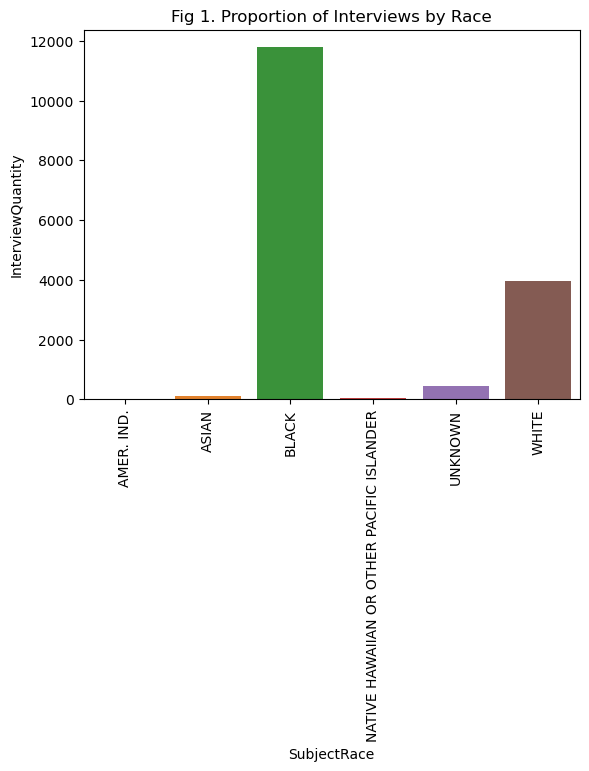

In [52]:
race_groupby_count = interview_data.groupby(by = "SubjectRace", as_index = True, dropna = True).count()["FieldInterviewID"].to_frame()
                                                                                                                                                   
race_groupby_count

race_groupby_plot = sns.barplot(race_groupby_count, x = race_groupby_count.index, y = "FieldInterviewID")
race_groupby_plot.set(ylabel = "InterviewQuantity")
race_groupby_plot.tick_params(axis='x', rotation=90)
race_groupby_plot.set(title = "Fig 1. Proportion of Interviews by Race")

[Text(0.5, 1.0, 'Fig 2. Proportion of Interviews by ZIP Code')]

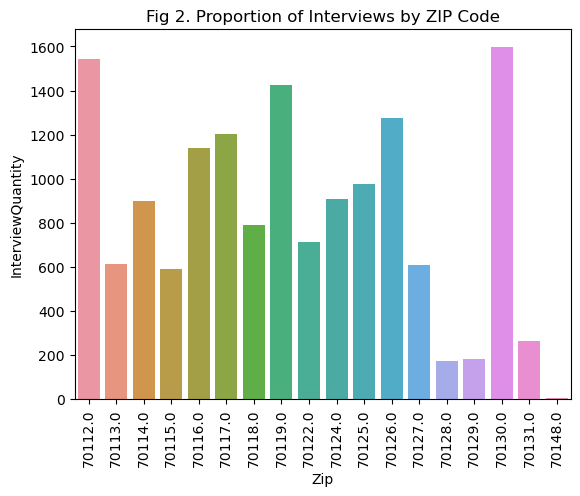

In [53]:
zip_groupby_count = interview_data.groupby(by = "Zip", as_index = True, dropna = True).count()["FieldInterviewID"].to_frame()
zip_groupby_count

zip_groupby_plot = sns.barplot(zip_groupby_count,x = zip_groupby_count.index, y = "FieldInterviewID")
zip_groupby_plot.set(ylabel = "InterviewQuantity")
zip_groupby_plot.tick_params(axis='x', rotation=90)
zip_groupby_plot.set(title = "Fig 2. Proportion of Interviews by ZIP Code")

[Text(0.5, 1.0, 'Fig 3. Proportion of Interviews by Stop Type')]

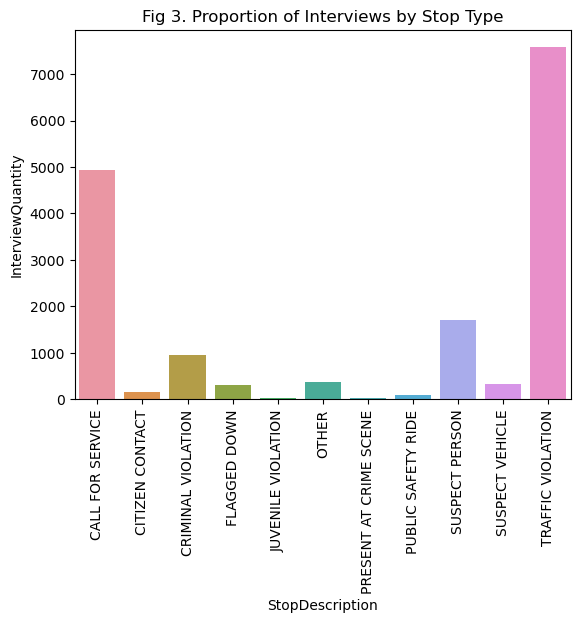

In [54]:
stoptype_groupby_count = interview_data.groupby(by = "StopDescription", as_index = True, dropna = True).count()["FieldInterviewID"].to_frame()
stoptype_groupby_count

stop_groupby_plot = sns.barplot(stoptype_groupby_count, x = stoptype_groupby_count.index, y = "FieldInterviewID")
stop_groupby_plot.set(ylabel = "InterviewQuantity")
stop_groupby_plot.tick_params(axis='x', rotation=90)
stop_groupby_plot.set(title = "Fig 3. Proportion of Interviews by Stop Type")